In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
from scipy.stats.mstats import gmean
import scipy.optimize as opt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import numpy as np
from pathlib import Path
from skimage import io

In [2]:
df = pd.read_excel(r'../data/lc-ms/ahl-accumulation.xls',sheet_name='data')
data = df[df.Time==13]

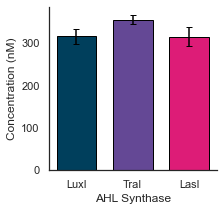

In [21]:
colors = ['#003f5c','#644895','#dd1c77']
sns.set_context('notebook')
sns.set_style('white')
f, ax = plt.subplots(figsize=(3,3))
ax.bar(data.AHL.unique(),data.Concentration,0.7,yerr=data.STD,label='Cell Biomass',edgecolor='k',color=colors,ecolor='black', capsize=3)
ax.set_xlabel('AHL Synthase')
ax.set_ylabel('Concentration (nM)')
sns.despine()
f.savefig(r'../Figures/13hrahl.pdf',bbox_inches='tight')

In [4]:
def clean_df(df):
    df.IPTG = (df.IPTG * 1e3)
    df.IPTG = df.IPTG.astype('int16')
    gb = df.groupby(['AHL','IPTG','Family'])
    lg = gb.AHL.transform(np.log10).sort_values()
    lg[lg == -np.inf] = 0
    lg = lg.astype('int32')
    lg.name = 'logAHL'
    return pd.concat([df,lg],axis=1)

In [5]:
p = Path('D:/qs-analysis/compiled-data/Figure 4')
p2 = Path('D:/qs-analysis/compiled-data/Figure 2')
if not (p / 'Data.pkl').exists() and not (p / 'mfi.pkl').exists():
    files = list(p.glob('**/*.pkl'))
    df = pd.DataFrame(columns=['FITC-A','AHL','IPTG','Family','Replicate'])
    for f in files:
        family = str(f.parent).split('\\')[-1]
        tmp = pd.read_pickle(f)
        df = df.append(tmp,ignore_index=True)
    Data = clean_df(df)
    cross_mfi = Data.groupby(['IPTG','Family','logAHL','Replicate']).median().reset_index()

    Data.to_pickle(p / 'Data.pkl')
    cross_mfi.to_pickle(p / 'mfi.pkl')
else:
    Data = pd.read_pickle(p / 'Data.pkl')
    cross_mfi = pd.read_pickle(p / 'mfi.pkl')
    mfi = pd.read_pickle(p2 / 'mfi.pkl')


In [6]:
cross_mfi

,IPTG,Family,logAHL,Replicate,FITC-A,AHL
0,0,LasR,-8,1,2030.160000,1.000000e-08
1,0,LasR,-8,2,2061.839931,1.000000e-08
2,0,LasR,-8,3,2051.279873,1.000000e-08
3,0,LasR,-7,1,2327.349922,1.000000e-07
4,0,LasR,-7,2,2323.200039,1.000000e-07
...,...,...,...,...,...,...
103,500,TraR,-7,2,1096.479927,1.000000e-07
104,500,TraR,-7,3,1078.879967,1.000000e-07
105,500,TraR,0,1,848.319969,0.000000e+00
106,500,TraR,0,2,890.889961,0.000000e+00


In [7]:
def colorFader(c1,c2,n): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    mix = np.linspace(0,1,n+1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    cols = list()
    for i in range(n):
        cols.append(mpl.colors.to_hex((1-mix[i])*c1 + mix[i]*c2))
    return cols

def AHL_cmap(Family,n,r=False):
    if Family == 'LuxR':
        c2='#ffffff' #white
        c1='#003f5c' #blue
        if not r:
            Lux_rgbs = colorFader(c1,c2,n)
        else:
            Lux_rgbs = colorFader(c2,c1,n)
        return matplotlib.colors.ListedColormap(Lux_rgbs, name='LuxR')
    elif Family == 'LasR':
        c2='#ffffff' #white
        c1='#dd1c77' #pink #
        if not r:
            Las_rgbs = colorFader(c1,c2,n)
        else:
            Las_rgbs = colorFader(c2,c1,n)
        return matplotlib.colors.ListedColormap(Las_rgbs, name='LasR')
    elif Family == 'TraR':
        c2='#ffffff' #white
        c1='#644895' #purple #
        if not r:
            Tra_rgbs = colorFader(c1,c2,n)
        else:
            Tra_rgbs = colorFader(c2,c1,n)
        return matplotlib.colors.ListedColormap(Tra_rgbs, name='TraR')
def AHL_cols(Family,n):
    if Family == 'LuxR':
        c2='#ffffff' #white
        c1='#003f5c' #blue
        return colorFader(c1,c2,n)
    elif Family == 'LasR':
        c2='#ffffff' #white
        c1='#dd1c77' #pink #
        return colorFader(c1,c2,n)

    elif Family == 'TraR':
        c2='#ffffff' #white
        c1='#644895' #purple #
        return colorFader(c1,c2,n)

In [8]:
AHL_cols('LuxR',3)

['#003f5c', '#557f92', '#aabfc9']

In [9]:
def make_heatmap(median_fluorescence,Family,ax=None, **kwargs):
    """
    This is a function to generate heatmaps
    
    Args:
        median_fluorescence (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry median fluorescence intensity (mfi)
        
        standard_deviation (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry standard deviation of fluorescence intensity (mfi)
        
        ax (plt.ax)
        Axis to plot data on
        
        **kwargs
        Addition arguments to pass to sns.heatmap
    """
    # sns.set_context('paper')
    ax = ax or plt.gca()
    mfi = median_fluorescence[median_fluorescence.Family ==Family]
    # normalized
    norm = mfi[mfi.logAHL != 0].copy()
    norm['FITC-A']=norm['FITC-A']/norm.groupby(['AHL','IPTG']).mean().max()['FITC-A']*100

    piv = norm.pivot_table(index='IPTG', columns='logAHL', values='FITC-A')
    g = sns.heatmap(piv, vmin=0,ax=ax,**kwargs)
    cbar = g.collections[0].colorbar
    cbar.set_ticks([0, 25, 50, 75,100])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    cbar.ax.set_ylabel('Relative Expression')
    ax.set_xlabel(r'AHL ($10^x$ M)')
    ax.set_ylabel(r'IPTG ($\mu M$)')
    #f.tight_layout()
    return 
def make_heatmap2(median_fluorescence,Family,ax=None, **kwargs):
    """
    This is a function to generate heatmaps
    
    Args:
        median_fluorescence (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry median fluorescence intensity (mfi)
        
        standard_deviation (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry standard deviation of fluorescence intensity (mfi)
        
        ax (plt.ax)
        Axis to plot data on
        
        **kwargs
        Addition arguments to pass to sns.heatmap
    """
    # sns.set_context('paper')
    ax = ax or plt.gca()
    mfi = median_fluorescence[(median_fluorescence.Family ==Family) & (median_fluorescence.logAHL !=0)]
    # normalized
    #norm = mfi[mfi.logAHL != 0].copy()
    #norm['FITC-A']=norm['FITC-A']/norm['FITC-A'].max()*100

    piv = mfi.pivot_table(index='IPTG', columns='logAHL', values='Ratio')
    g = sns.heatmap(piv, ax=ax,**kwargs)
    cbar = g.collections[0].colorbar
    #cbar.set_ticks([0, 25, 50, 75,100])
    #cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    cbar.ax.set_ylabel(r'Relative expression ($\frac{mNG_{ec}}{mNG_{se}}$)')
    ax.set_xlabel(r'AHL ($10^x$ M)')
    ax.set_ylabel(r'IPTG ($\mu M$)')
    #f.tight_layout()
    return 

In [10]:
from matplotlib import transforms
def label_panel(ax, letter, *,
                offset_left=0.5, offset_up=0.2, prefix='', postfix='', **font_kwds):
    kwds = dict(fontsize=18)
    kwds.update(font_kwds)
    # this mad looking bit of code says that we should put the code offset a certain distance in
    # inches (using the fig.dpi_scale_trans transformation) from the top left of the frame
    # (which is (0, 1) in ax.transAxes transformation space)
    fig = ax.figure
    trans = ax.transAxes + transforms.ScaledTranslation(-offset_left, offset_up, fig.dpi_scale_trans)
    ax.text(0, 1, prefix+letter+postfix, transform=trans, **kwds)

def label_panels(axes, letters=None, **kwds):
    if letters is None:
        letters = axes.keys()
    for letter in letters:
        ax = axes[letter]
        label_panel(ax, letter, **kwds)

In [11]:
Lux_cmap = AHL_cmap('LuxR',100)
Las_cmap = AHL_cmap('LasR',100)
Tra_cmap = AHL_cmap('TraR',100)
Lux_cmap_r = AHL_cmap('LuxR',100,r=True)
Las_cmap_r = AHL_cmap('LasR',100,r=True)
Tra_cmap_r = AHL_cmap('TraR',100,r=True)

In [12]:
se = mfi.groupby(['IPTG','Family','AHL']).mean()['FITC-A'].reset_index()
cross = cross_mfi.groupby(['IPTG','Family','AHL']).mean()['FITC-A'].reset_index()
comparison = pd.merge(cross,se,on=['IPTG','Family','AHL'])
comparison.loc[:,'Ratio'] = comparison.loc[:,'FITC-A_x']/comparison.loc[:,'FITC-A_y']*100
comparison = comparison[comparison.AHL !=0]
#comparison.join(,on=['IPTG','Family','logAHL'],how='left',lsuffix='_l',rsuffix='_r')
#f, ax = plt.subplots()
#make_heatmap2(comparison,'LuxR',ax,cmap=Lux_cmap_r)

In [13]:
cross_mfi = cross_mfi[cross_mfi.AHL!=0]

In [14]:
cross_mfi.head()

,IPTG,Family,logAHL,Replicate,FITC-A,AHL
0,0,LasR,-8,1,2030.160000,1.000000e-08
1,0,LasR,-8,2,2061.839931,1.000000e-08
2,0,LasR,-8,3,2051.279873,1.000000e-08
3,0,LasR,-7,1,2327.349922,1.000000e-07
4,0,LasR,-7,2,2323.200039,1.000000e-07


In [15]:
cross.loc[cross.Family=='LuxR']

,IPTG,Family,AHL,FITC-A
4,0,LuxR,0.000000e+00,949.869995
5,0,LuxR,1.000000e-09,956.976644
6,0,LuxR,1.000000e-08,1004.293335
7,0,LuxR,1.000000e-07,1838.019969
16,5,LuxR,0.000000e+00,1013.173333
17,5,LuxR,1.000000e-09,1010.463332
18,5,LuxR,1.000000e-08,1530.220011
19,5,LuxR,1.000000e-07,5602.079922
28,500,LuxR,0.000000e+00,1057.883341
29,500,LuxR,1.000000e-09,1272.996651


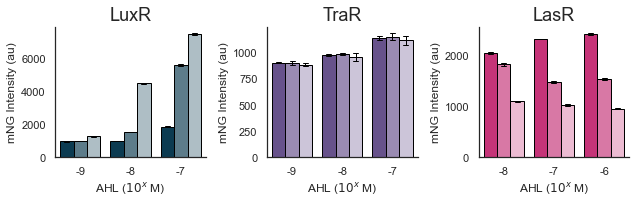

In [20]:
colors = ['#003f5c','#644895','#dd1c77']
sns.set_context('notebook')
sns.set_style('white')
families = ['LuxR','TraR','LasR']
locations=['upper left','upper left','upper right']
f, axes = plt.subplots(ncols=3,figsize=(9,3))

for ax,family in zip(axes.ravel(),families):
    sns.barplot(x='logAHL',y='FITC-A',hue='IPTG',ci='sd',data=cross_mfi.loc[cross_mfi.Family==family],ax=ax,palette=AHL_cols(family,3),edgecolor='k',capsize=.1,errcolor='k',errwidth=1)
    ax.set_title(family,fontsize=18)
    ax.legend_.remove()
    #ax.legend(title=r'IPTG ($\mu$M)',loc='upper left')
    ax.set_xlabel(r'AHL ($10^x$ M)')
    ax.set_ylabel('mNG Intensity (au)')
sns.despine()
f.tight_layout()
f.savefig(r'../Figures/cross-activation.pdf',bbox_inches='tight')
